In [1]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
from transformers import CLIPProcessor, CLIPModel

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

from tqdm import tqdm

# Task 1: Zero-Shot Classification with Foundation Models

### Objective
The goal of this task is to explore the **EuroSAT dataset** and apply zero-shot classification using a **pre-trained CLIP model**. We will evaluate how well CLIP can classify satellite images using textual descriptions without any dataset-specific training.

### Steps in this Notebook
1. **Data** - Understand the structure and contents of EuroSAT.



## Data: EuroSAT Dataset

### Overview
The **EuroSAT dataset** consists of RGB satellite images categorized into 10 land cover classes. Let's analyze the structure.

Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Class distribution: {'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}


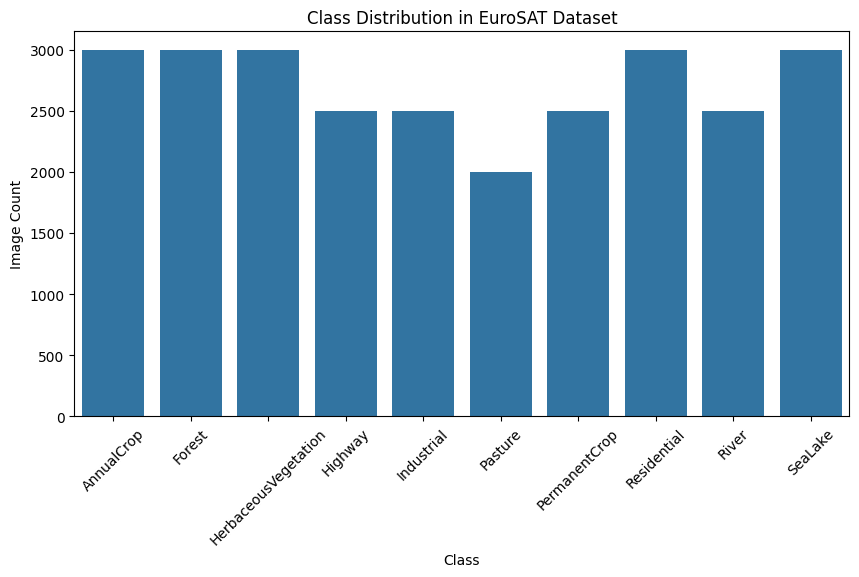

In [2]:
# classes check
dataset_path = "2750/"

classes = sorted([cls for cls in os.listdir(dataset_path) if not cls.startswith('.')])

print(f"Classes found: {classes}")

class_counts = {cls: len(glob(os.path.join(dataset_path, cls, "*.jpg"))) for cls in classes}
print(f"Class distribution: {class_counts}")

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Image Count", data=df_counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.show()


In [3]:
# channels and resolution check
image_info = []

for cls in classes:
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]
    img = Image.open(img_path)
    image_info.append((cls, img.mode, img.size))

df_info = pd.DataFrame(image_info, columns=["Class", "Mode", "Resolution"])

print(df_info)

unique_modes = df_info["Mode"].unique()
unique_resolutions = df_info["Resolution"].unique()

print(f"\nUnique image modes found: {unique_modes}")
print(f"Unique image resolutions found: {unique_resolutions}")


                  Class Mode Resolution
0            AnnualCrop  RGB   (64, 64)
1                Forest  RGB   (64, 64)
2  HerbaceousVegetation  RGB   (64, 64)
3               Highway  RGB   (64, 64)
4            Industrial  RGB   (64, 64)
5               Pasture  RGB   (64, 64)
6         PermanentCrop  RGB   (64, 64)
7           Residential  RGB   (64, 64)
8                 River  RGB   (64, 64)
9               SeaLake  RGB   (64, 64)

Unique image modes found: ['RGB']
Unique image resolutions found: [(64, 64)]


#### **Dataset Structure**
- Folder: `2750/`
- Subfolders (each corresponding to a class):
  - `AnnualCrop/`
  - `Forest/`
  - `HerbaceousVegetation/`
  - `Highway/`
  - `Industrial/`
  - `Pasture/`
  - `PermanentCrop/`
  - `Residential/`
  - `River/`
  - `SeaLake/`
- Each subfolder contains from 2000 to 3000 images named as `{class_name}_{i}.jpg` (e.g., `Forest_102.jpg`). So overall the different classes are quite balanced.
- Images are repesentes as RGB satellite images with 64×64 pixels resolution.

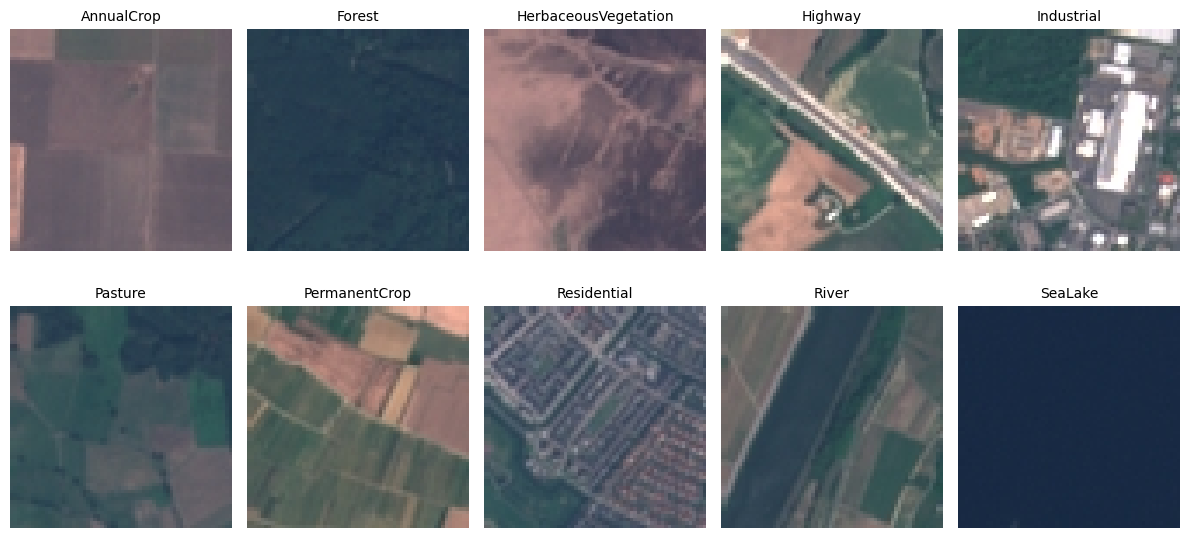

In [4]:
# visualization
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, cls in enumerate(classes):
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]  
    img = Image.open(img_path)

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(cls, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


Many of them looks quite similar such that it would be difficult to be classified for also for a human.

At the moment, "Highway" and "River" looks like may be confused, as well as the "Residential" and "Industrial" classes or the "AnnualCrop" and "Pasture".

## CLIP: Zero-Shot Classification with Foundation Models
In this section, we implement zero-shot classification using **CLIP** to classify EuroSAT satellite images without dataset-specific training.  

We start by defining a function that classifies a single image, ensuring efficiency and flexibility. Then, we apply it to a single class before running it on the entire dataset to evaluate performance across all land cover types.  

To determine the best approach, we test four configurations, varying image rescaling and prompting to analyze their impact on classification accuracy.


In [12]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "./clip_model"  # Change this to your actual path
model = CLIPModel.from_pretrained(model_path).to(device)
processor = CLIPProcessor.from_pretrained(model_path)

### Single Image Classification 
We define a function that loads CLIP once and allows for customization:  
- **Resizing**: Optional rescaling to 224x224, CLIP’s expected input size.  
- **Prompting**: Either `"A satellite image of <class>"` or just the class name.  
- **Output Format**: Return either the best class or all probabilities for deeper analysis.  

These options allow us to test four setups, combining different prompts and rescaling choices to evaluate their impact on classification accuracy.


In [14]:
def classify_image_clip(
    image_path, 
    class_names, 
    prompt_type="default",  # "default" (uses "A satellite image of"), "none" (just class name)
    rescale=False,  # Whether to rescale image to CLIP’s expected 224x224
    return_all=False  # If True, return all class probabilities; else return best class
):
    """
    Classifies a single image using CLIP in a zero-shot manner.

    Parameters:
    - image_path (str): Path to the image.
    - class_names (list): List of class labels.
    - prompt_type (str): "default" (adds 'A satellite image of') or "none" (just the class name).
    - rescale (bool): If True, rescale image to 224x224 (recommended for CLIP).
    - return_all (bool): If True, return all class probabilities; otherwise, return the best class.

    Returns:
    - If return_all=False: (str) Best class name.
    - If return_all=True: (dict) Class probabilities.
    """

    image = Image.open(image_path).convert("RGB")
    if rescale:
        image = image.resize((224, 224))

    text_inputs = [f"A satellite image of {cls}" for cls in class_names] if prompt_type == "default" else class_names

    inputs = processor(text=text_inputs, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to GPU if available

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    class_probs = {class_names[i]: probs[0, i].item() for i in range(len(class_names))}

    if return_all:
        return class_probs
    else:
        return max(class_probs, key=class_probs.get)

In [15]:
image_path = "2750/Forest/Forest_100.jpg"
best_class = classify_image_clip(image_path, classes)
print(f"Predicted Class: {best_class}")

Predicted Class: Forest


### Single-Class Analysis  
Before testing the full dataset, we apply CLIP to one class (`Forest`).  

We expect some correct classifications, but also errors due to CLIP's lack of satellite-specific training. This helps identify potential challenges before scaling up.

In [16]:
eval_class = "SeaLake"
eval_class_index = classes.index(eval_class)

image_paths = glob(os.path.join(dataset_path, eval_class, "*.jpg"))

print(f"Evaluating {len(image_paths)} images from class '{eval_class}'")

Evaluating 3000 images from class 'SeaLake'


In [17]:
true_labels = [eval_class_index] * len(image_paths)
predicted_labels = []

for img_path in tqdm(image_paths, desc="Classifying Images"):
    predicted_class = classify_image_clip(img_path, classes)
    predicted_labels.append(classes.index(predicted_class))


Classifying Images: 100%|██████████| 3000/3000 [01:12<00:00, 41.37it/s]


Zero-Shot Classification Accuracy for 'SeaLake': 19.00%


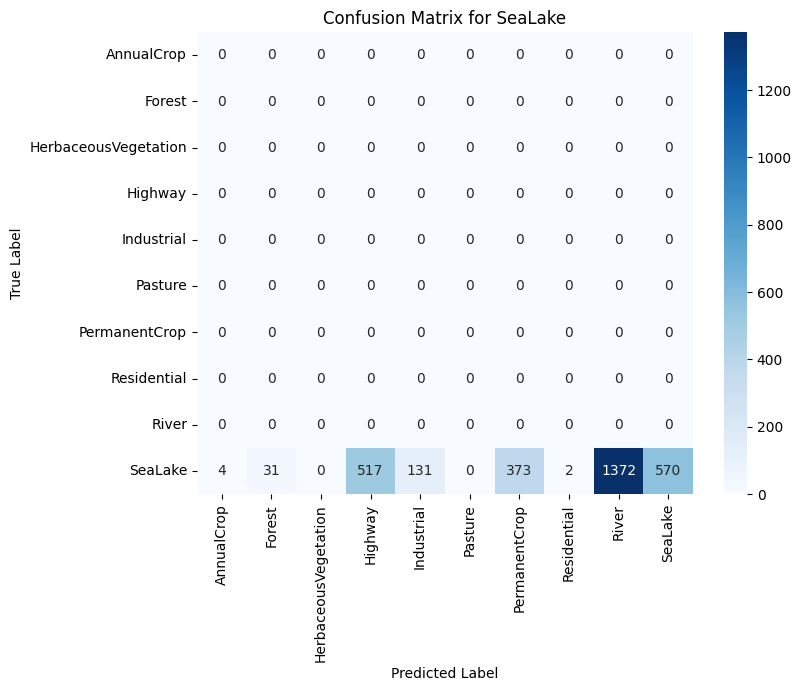

In [18]:
accuracy = accuracy_score(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(classes))))

print(f"Zero-Shot Classification Accuracy for '{eval_class}': {accuracy * 100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {eval_class}")
plt.show()

### Whole Dataset Classification
We now classify the entire dataset using the four different configurations.  

By analyzing overall accuracy, per-class accuracy, and confusion matrices**, we aim to determine which approach works best for zero-shot land cover classification with CLIP.


#### 1) Full Prompt with Original Size

In [ ]:
true_labels = []
predicted_labels = []
class_accuracies = {}

for eval_class in tqdm(classes, desc="Processing Classes (Full Prompt + Original Size)"):
    eval_class_index = classes.index(eval_class)
    image_paths = glob(os.path.join(dataset_path, eval_class, "*.jpg"))
    
    correct_preds = 0
    total_images = len(image_paths)

    for img_path in image_paths:
        predicted_class = classify_image_clip(img_path, classes, prompt_type="default", rescale=False)
        predicted_class_index = classes.index(predicted_class)
        
        predicted_labels.append(predicted_class_index)
        true_labels.append(eval_class_index)
        
        if predicted_class_index == eval_class_index:
            correct_preds += 1

    class_accuracy = correct_preds / total_images
    class_accuracies[eval_class] = class_accuracy * 100

overall_accuracy = accuracy_score(true_labels, predicted_labels) * 100
cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(classes))))

print(f"\nOverall Accuracy (Full Prompt + Original Size): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Full Prompt + Original Size)")
plt.show()


#### 2) Full-Prompt with Rescaling

In [ ]:
true_labels = []
predicted_labels = []
class_accuracies = {}

for eval_class in tqdm(classes, desc="Processing Classes (Full Prompt + Rescaling)"):
    eval_class_index = classes.index(eval_class)
    image_paths = glob(os.path.join(dataset_path, eval_class, "*.jpg"))
    
    correct_preds = 0
    total_images = len(image_paths)

    for img_path in image_paths:
        predicted_class = classify_image_clip(img_path, classes, prompt_type="default", rescale=True)
        predicted_class_index = classes.index(predicted_class)
        
        predicted_labels.append(predicted_class_index)
        true_labels.append(eval_class_index)
        
        if predicted_class_index == eval_class_index:
            correct_preds += 1

    class_accuracy = correct_preds / total_images
    class_accuracies[eval_class] = class_accuracy * 100

overall_accuracy = accuracy_score(true_labels, predicted_labels) * 100
cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(classes))))

print(f"\nOverall Accuracy (Full Prompt + Rescaling): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Full Prompt + Rescaling)")
plt.show()


#### 3) No Prompt with Original Size

In [ ]:
true_labels = []
predicted_labels = []
class_accuracies = {}

for eval_class in tqdm(classes, desc="Processing Classes (No Prompt + Original Size)"):
    eval_class_index = classes.index(eval_class)
    image_paths = glob(os.path.join(dataset_path, eval_class, "*.jpg"))
    
    correct_preds = 0
    total_images = len(image_paths)

    for img_path in image_paths:
        predicted_class = classify_image_clip(img_path, classes, prompt_type="none", rescale=False)
        predicted_class_index = classes.index(predicted_class)
        
        predicted_labels.append(predicted_class_index)
        true_labels.append(eval_class_index)
        
        if predicted_class_index == eval_class_index:
            correct_preds += 1

    class_accuracy = correct_preds / total_images
    class_accuracies[eval_class] = class_accuracy * 100

overall_accuracy = accuracy_score(true_labels, predicted_labels) * 100
cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(classes))))

print(f"\nOverall Accuracy (No Prompt + Original Size): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (No Prompt + Original Size)")
plt.show()


#### 4) No Prompt with Rescaling

In [ ]:
true_labels = []
predicted_labels = []
class_accuracies = {}

for eval_class in tqdm(classes, desc="Processing Classes (No Prompt + Rescaling)"):
    eval_class_index = classes.index(eval_class)
    image_paths = glob(os.path.join(dataset_path, eval_class, "*.jpg"))
    
    correct_preds = 0
    total_images = len(image_paths)

    for img_path in image_paths:
        predicted_class = classify_image_clip(img_path, classes, prompt_type="none", rescale=True)
        predicted_class_index = classes.index(predicted_class)
        
        predicted_labels.append(predicted_class_index)
        true_labels.append(eval_class_index)
        
        if predicted_class_index == eval_class_index:
            correct_preds += 1

    class_accuracy = correct_preds / total_images
    class_accuracies[eval_class] = class_accuracy * 100

overall_accuracy = accuracy_score(true_labels, predicted_labels) * 100
cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(len(classes))))

print(f"\nOverall Accuracy (No Prompt + Rescaling): {overall_accuracy:.2f}%\n")
print("Accuracy per Class:")
for cls, acc in class_accuracies.items():
    print(f"  - {cls}: {acc:.2f}%")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (No Prompt + Rescaling)")
plt.show()
